# Max condition number w/ positive gains

Tests maximum condition number that can be whitened with exclusively positve gains
at each orientation by the Mercedes Benz frame in R2.

In [1]:
import numpy as np
import frame_whitening as fw
import frame_whitening.plot as fwplt
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir(os.path.expanduser("~/frame_whitening"))
print(os.getcwd())

/mnt/home/lduong/frame_whitening


In [ ]:

W = fw.get_mercedes_frame(parseval=False, jitter=False)
print(np.linalg.norm(W, axis=0))

dt = np.pi / 48
all_thetas = np.arange(0, 2*np.pi + dt, dt)
kappas = np.ones_like(all_thetas)

all_kappas = np.concatenate((np.arange(1, 100, 0.1), np.ones(1) * 10000))

eps = 1e-6
angles_to_plot = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0]
cols = sns.color_palette("husl", n_colors=len(angles_to_plot))
covs = []
for i, th in enumerate(all_thetas):
    V = fw.rot2(th)  # 2d rotation matrix

    for k in all_kappas:
        cov = V @ np.diag([k, 1.0]) * (2 / (k + 1)) @ V.T
        cov_sqrt = fw.psd_sqrt(cov)
        g = fw.compute_g_opt(cov_sqrt, W)
        if np.all(g > 0):
            kappas[i] = k
    if np.round(np.rad2deg(th)) in angles_to_plot:
        cov_plot = V @ np.diag([kappas[i], 1.0]) * (2 / (kappas[i] + 1)) @ V.T
        covs.append(cov_plot)

print(
    f"deg where min-max is achieved: {np.rad2deg(all_thetas[np.argmin(kappas)]):.2f} deg"
)

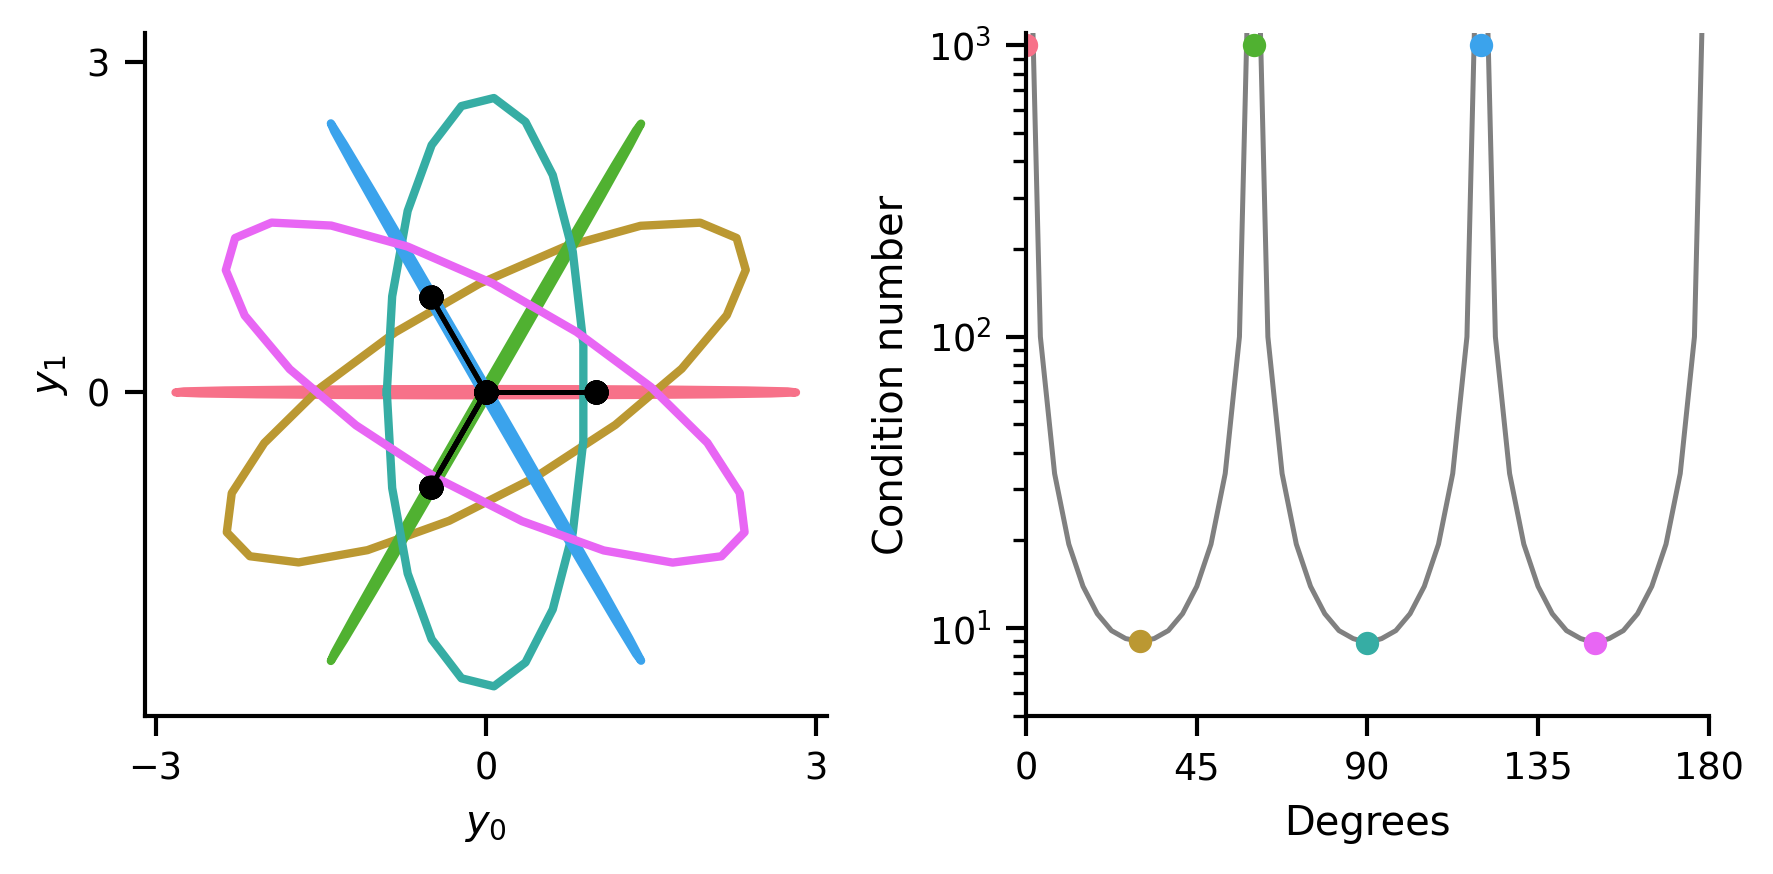

In [51]:
with sns.plotting_context("paper", font_scale=1):
    fig, ax = plt.subplots(1, 2, dpi=300)
    for counter, cov_plot in enumerate(covs):
        fwplt.plot_ellipse(cov_plot, ax=ax[0], **{"color": cols[counter]}, linewidth=2)
        fwplt.plot_frame2d(W, ax[0], color="k")

    for i, theta in enumerate(angles_to_plot):
        k = kappas[np.argmin(np.abs(all_thetas - np.deg2rad(theta)))]
        ax[1].scatter(theta, np.min([k, 1000]), color=cols[i])
    ax[1].plot(np.rad2deg(all_thetas), kappas, color="grey", zorder=-1)

    ax[1].hlines(1.0, 0, 180, linestyles="--", color="grey")
    ax[0].set( xlabel=r"$y_0$", ylabel="$y_1$", xticks=(-3, 0, 3), yticks=(-3, 0, 3))
    ax[0].axis("square")
    ax[1].set(
        ylabel="Condition number",
        xlabel="Degrees",
        xlim=(0, 180),
        ylim=(5, 1e3 + 100),
        yscale="log",
        xticks=np.linspace(0, 180, 5),
        box_aspect=1
    )
    fig.tight_layout()
    sns.despine()

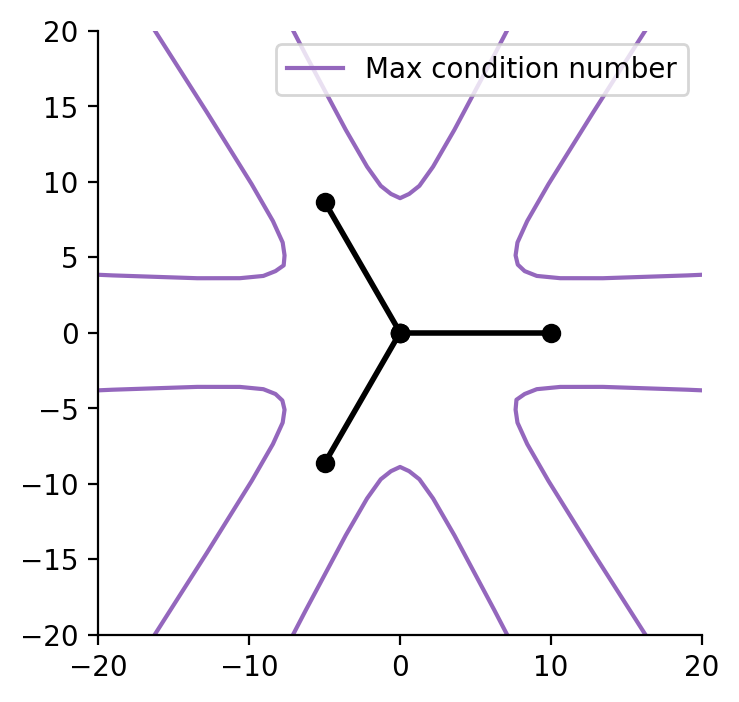

In [60]:
fig, ax = plt.subplots(1, 1, dpi=200)
x = kappas * np.cos(all_thetas)
y = kappas * np.sin(all_thetas)

ax.plot(x, y, color="C4", label="Max condition number")
ax.axis('square')
fwplt.plot_frame2d(W*10, ax=ax)
lims = (-20, 20)
ax.set(xlim=lims, ylim=lims)
sns.despine()
ax.legend(loc='upper right')

In [ ]:
fig.savefig(
    "figures/fig_outputs/cond_number_r2.png",
    transparent=True,
    bbox_inches="tight",
    dpi=300,
)